<a href="https://colab.research.google.com/github/swapnilbarai/FRONT-END-FOR-KYC/blob/master/Copy_of_NewCrackModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
train_data=[]
def preprocessing_data(Positive,Negative):
    for img in os.listdir(Positive):
        train_data.append((os.path.join(Positive,img),1))
    temp=[]
    for img in os.listdir(Negative):
        temp.append((os.path.join(Negative,img),0))
    random.shuffle(temp)
    for i in range(len(os.listdir(Positive))):
        img,label=temp[i]
        train_data.append((img,label))

    

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
WP='drive/MyDrive/W/CW'
WN='drive/MyDrive/W/UW'
DP='drive/MyDrive/D/CD'
DN='drive/MyDrive/D/UD'
PP='drive/MyDrive/P/CP'
PN='drive/MyDrive/P/UP'
FP='drive/MyDrive/F/Positive'
FN='drive/MyDrive/F/Negative'
preprocessing_data(WP,WN)
preprocessing_data(DP,DN)
preprocessing_data(PP,PN)


In [ ]:
for img in os.listdir(FP):
        train_data.append((os.path.join(FP,img),1))
for img in os.listdir(FN):
        train_data.append((os.path.join(FN,img),0))



In [ ]:
print(len(train_data))

56969


In [ ]:
import pandas as pd
train_data = pd.DataFrame(train_data, columns=["filepath","cracks"])
print(train_data.head())
np.random.seed(42)
msk = np.random.rand(len(train_data)) < 0.9

train_df = train_data[msk].reset_index()
val_df = train_data[~msk].reset_index()

                          filepath  cracks
0  drive/MyDrive/W/CW/7115-216.jpg       1
1  drive/MyDrive/W/CW/7115-193.jpg       1
2  drive/MyDrive/W/CW/7115-131.jpg       1
3  drive/MyDrive/W/CW/7115-227.jpg       1
4  drive/MyDrive/W/CW/7115-244.jpg       1


In [4]:
import torch
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F

class ConcreteDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df
        self.transforms = transforms
        self.is_test = is_test
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
#         row = self.df.iloc[idx]
        img = Image.open(self.df.iloc[idx]['filepath'])
        img=img.resize((224,224))
        if self.transforms:
             img = self.transforms(**{"image": np.array(img)})["image"]
        if self.is_test:
            return img
        else:
            cracks_tensor = torch.tensor([self.df.iloc[idx]['cracks']], dtype=torch.int64)
            return img, cracks_tensor



In [5]:
imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
train_tfms = A.Compose([
    A.Cutout(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    ToTensor(normalize=imagenet_stats)
        ])
    
test_tfms = A.Compose([
        ToTensor(normalize=imagenet_stats)
        ])

In [ ]:
train_ds = ConcreteDataset(train_df, transforms=train_tfms)
val_ds = ConcreteDataset(val_df, transforms=test_tfms, is_test=False)
len(train_ds), len(val_ds)

(51299, 5670)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=64, 
                    num_workers=2, pin_memory=True)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from torchvision import  models
model = models.resnet50(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False  
model.fc = nn.Sequential(
               nn.Linear(2048, 512),
               nn.ReLU(inplace=True),
               nn.Linear(512, 64),nn.ReLU(inplace=True),
               nn.Linear(64,2),nn.ReLU(),nn.LogSoftmax(dim=1)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
import torch.optim as optim

opt = optim.Adam(model.parameters(),lr=1e-5)
loss_fn=nn.CrossEntropyLoss()
Training_loss=[]
Training_acc=[]
Validation_loss=[]
Validation_acc=[]
for x in range(30):
    model.train()
    training_loss=0.0
    validation_loss=0.0
    training_acc=0
    validation_acc=0
    i=0
    for inputs,targets in train_dl:
        inputs=inputs.to(device)
        targets=targets.to(device)
        opt.zero_grad()
        outputs=model(inputs)
        preds = torch.argmax(outputs,dim=1)
        #print(outputs.shape,targets.shape)
        loss=F.nll_loss(outputs,targets.squeeze())
        loss.backward()
        opt.step()
        training_loss += loss.data.item() * inputs.size(0)
        training_acc+=torch.sum(preds==targets.squeeze()) 
        if i%100==0:
          print(training_acc)
        i=i+1
    training_loss/=len(train_dl)

    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(x+1,30,training_loss,training_acc/512.99))
    model.eval()
    for inputs,targets in val_dl:
        inputs=inputs.to(device)
        targets=targets.to(device)
        outputs=model(inputs)
        preds = torch.argmax(outputs,dim=1)
        validation_loss+=loss.data.item()*inputs.size(0)
        validation_acc+=torch.sum(preds==targets.squeeze())
    validation_loss/=len(val_dl)
    print('Epoch {:.0f}/{:.0f} : Validation loss: {:.4f} | Validation Accuracy: {:.4f}'.format(x+1,30,validation_loss,validation_acc/56.7))
    Training_loss.append(training_loss)
    Training_acc.append(training_acc)
    Validation_loss.append(validation_loss)
    Validation_acc.append(validation_acc)


tensor(58, device='cuda:0')
tensor(5838, device='cuda:0')
tensor(11644, device='cuda:0')
tensor(17398, device='cuda:0')
tensor(23135, device='cuda:0')
tensor(28960, device='cuda:0')
tensor(34742, device='cuda:0')
tensor(40542, device='cuda:0')
tensor(46304, device='cuda:0')
Epoch 1/30 : Training loss: 14.6125 | Training Accuracy: 90.3273
Epoch 1/30 : Validation loss: 11.8723 | Validation Accuracy: 91.5873
tensor(59, device='cuda:0')
tensor(5878, device='cuda:0')
tensor(11697, device='cuda:0')
tensor(17489, device='cuda:0')
tensor(23349, device='cuda:0')
tensor(29188, device='cuda:0')
tensor(34954, device='cuda:0')
tensor(40796, device='cuda:0')
tensor(46622, device='cuda:0')
Epoch 2/30 : Training loss: 13.2729 | Training Accuracy: 90.9472
Epoch 2/30 : Validation loss: 10.7719 | Validation Accuracy: 92.2575
tensor(55, device='cuda:0')
tensor(5862, device='cuda:0')
tensor(11715, device='cuda:0')
tensor(17539, device='cuda:0')
tensor(23343, device='cuda:0')
tensor(29170, device='cuda:0')


In [ ]:
train_acc=[]
valid_acc=[]
for i in range(30):
  train_acc.append(Training_acc[i]/512.99)
  valid_acc.append(Validation_acc[i]/56.7)


Text(0, 0.5, 'Accuracy')

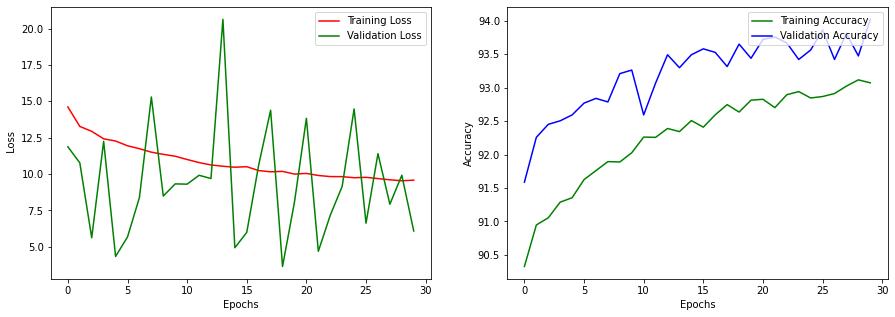

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(range(30),Training_loss,'r-',label='Training Loss') 
plt.plot(range(30),Validation_loss,'g-',label='Validation Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel(' Loss')
plt.subplot(122)
plt.plot(range(30),train_acc,'g-',label='Training Accuracy') 
plt.plot(range(30),valid_acc,'b-',label='Validation Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


In [ ]:
checkpoint={'model':model,'state_dict':model.state_dict(),'optimizer':opt.state_dict()}
torch.save(checkpoint,'drive/MyDrive/F/newcrackmodel.pth')

In [7]:
image1='drive/MyDrive/F/IMG_20210130_100414.jpg'
image2='drive/MyDrive/F/IMG_20210130_100357.jpg'
checkpoint=torch.load('drive/MyDrive/F/newcrackmodel.pth')
model1=checkpoint['model']
model1.load_state_dict(checkpoint['state_dict'])
model1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
import pandas as pd
def test_fn(imagepath,label):
  temp=[]
  temp.append((imagepath,label))
  temp = pd.DataFrame(temp, columns=["filepath","cracks"])
  temp_ds = ConcreteDataset(temp, transforms=test_tfms, is_test=False)
  temp_dl = DataLoader(temp_ds, batch_size=64, 
                    num_workers=2, pin_memory=True)
  for inputs,targets in temp_dl:
    inputs=inputs.to(device)
    targets=targets.to(device)
    outputs=model1(inputs)
    preds = torch.argmax(outputs,dim=1)
    print(outputs)
    if torch.sum(preds==targets.squeeze()):
      print("Model has predicted correct output")

  




In [31]:
import cv2
def show1(ImagePath):
  
  fig,a =  plt.subplots(1,1)
  fig.set_figheight(10)
  fig.set_figwidth(10)
  
  for i in range(1):
    img = cv2.imread(str(ImagePath))
    img=cv2.resize(img,(224,224))
    a.imshow(img)
    title = "Good Concrete " + str(i)
    a.set_title(title)

tensor([[-7.8401e+00, -3.9367e-04]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
Model has predicted correct output


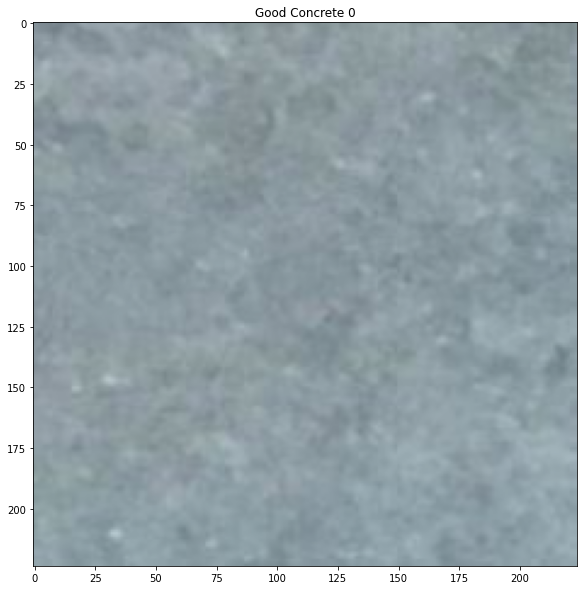

In [33]:
image3='drive/MyDrive/F/Negative/19999.jpg'
test_fn(image1,1)
show1(image3)

In [9]:
!unzip "/content/drive/My Drive/TestingConcrete.zip" -d "/content/drive/My Drive/"

Archive:  /content/drive/My Drive/TestingConcrete.zip
   creating: /content/drive/My Drive/TestingConcrete/
   creating: /content/drive/My Drive/TestingConcrete/Positive/
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210131_100715.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210131_100347.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210131_100330.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210131_100042.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210131_100010.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210131_095656.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210130_100414.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210130_100357.jpg  
  inflating: /content/drive/My Drive/TestingConcrete/Positive/IMG_20210131_095728.jpg  
   creating: /content/drive/My Drive/

In [18]:
P='/content/drive/MyDrive/TestingConcrete/Positive'
N='/content/drive/MyDrive/TestingConcrete/Negative'
temp1=[]

for img in os.listdir(P):
  temp1.append((os.path.join(P,img),1))

for img in os.listdir(N):
  temp1.append((os.path.join(N,img),0))

temp1 = pd.DataFrame(temp1, columns=["filepath","cracks"])
temp1_ds = ConcreteDataset(temp1, transforms=test_tfms, is_test=False)
temp1_dl = DataLoader(temp1_ds, batch_size=64, 
                  num_workers=2, pin_memory=True)
test_acc=0.0
for inputs,targets in temp1_dl:
    inputs=inputs.to(device)
    targets=targets.to(device)
    outputs=model1(inputs)
    preds = torch.argmax(outputs,dim=1)
    print(preds)
    test_acc+= torch.sum(preds==targets.squeeze())
    print("Model has predicted correct output for ",test_acc,"Out of ",len(temp1_ds))
  


tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Model has predicted correct output for  tensor(13., device='cuda:0') Out of  15
